# Scratch CNN

In this notebook we will address the problem of training a CNN from scratch to classify breast abnormalities, we will distinguish between benign and malignant.

In [1]:
# Needed to import the utils file
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=7d10cc8d5c8b79b27850e87f9525364db765c0fa6b714c19b9507451526aa737
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Move in the folder to import the utils file
%cd '/content/gdrive/MyDrive/Colab Notebooks'

/content/gdrive/MyDrive/Colab Notebooks


In [4]:
import import_ipynb
import Utils as ut
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential

importing Jupyter notebook from Utils.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data preprocessing
We apply to the dataset the following preprocessing steps:

* Binarize the dataset: initially it contains 5 classes (baseline, mass_benign, mass_malignant, calcification_benign, calcification_malignant), we will discard the baselines patches (healthy tissue) and we will binarize the 4 classes of abnormalities into 2 classes (benign, malignant).

* We normalize between [0,1] the tensors.
* We add the channel dimension to the tensors, from (150,150) to (150,150,1).

In [5]:
images, labels = ut.load_training()
test_images, test_labels = ut.load_test()

In [6]:
dataset, lab = ut.binarize(images, labels, 'benign_malignant')

In [7]:
dataset, lab = ut.shuffle_dataset(dataset, lab) # The dataset is ordered by class, we need to shuffle it.
dataset = ut.rescale(dataset)
dataset = np.expand_dims(dataset, axis=3)
ut.properties(dataset)

Properties: 
Shape: (2676, 150, 150, 1)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


## Training
As the dataset is unbalanced, we will perform the training (and the evaluation) with weighted classes.

In [8]:
mc_weights = class_weight.compute_class_weight('balanced', np.unique(lab), lab)
mc_weights = dict(enumerate(mc_weights))
print('Class weights: ', mc_weights)

Class weights:  {0: 0.8533163265306123, 1: 1.2075812274368232}


In [18]:
BATCH_SIZE = 64

The dataset is too small to perform a training of a CNN from scratch, so we perform data augmentation.

In [19]:
data_augmentation = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_set = data_augmentation.flow(dataset, lab, batch_size=BATCH_SIZE, seed=42, subset='training')
valid_set = data_augmentation.flow(dataset, lab, batch_size=BATCH_SIZE, seed=42, subset='validation')

### Network architecure

In [20]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(150,150,1)),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(64, 5, activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(128, 5, activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
], name='benign_malignant')

model.summary()

Model: "benign_malignant"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       204928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 256)  

In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                   mode='max', 
                                   patience=20,  
                                   restore_best_weights=True),
             
  tf.keras.callbacks.ModelCheckpoint('models/scratch_bm_64_4.h5', 
                                     monitor='val_accuracy', 
                                     mode='max',
                                    save_best_only=True)]

history_mc = model.fit(train_set,
            shuffle=True,
            epochs=100,
            batch_size=BATCH_SIZE,
            validation_data=valid_set,
            callbacks=callbacks,
            class_weight=mc_weights,
            verbose=1)

Epoch 1/100
34/34 [==============================] - 6s 147ms/step - loss: 0.6937 - accuracy: 0.4791 - val_loss: 0.6956 - val_accuracy: 0.4318
Epoch 2/100
34/34 [==============================] - 5s 133ms/step - loss: 0.6895 - accuracy: 0.4792 - val_loss: 0.7015 - val_accuracy: 0.4355
Epoch 3/100
34/34 [==============================] - 5s 133ms/step - loss: 0.6892 - accuracy: 0.5067 - val_loss: 0.6863 - val_accuracy: 0.5907
Epoch 4/100
34/34 [==============================] - 5s 134ms/step - loss: 0.6849 - accuracy: 0.5321 - val_loss: 0.6971 - val_accuracy: 0.4710
Epoch 5/100
34/34 [==============================] - 5s 134ms/step - loss: 0.6633 - accuracy: 0.5408 - val_loss: 0.6685 - val_accuracy: 0.5458
Epoch 6/100
34/34 [==============================] - 5s 133ms/step - loss: 0.6511 - accuracy: 0.5506 - val_loss: 0.6415 - val_accuracy: 0.5607
Epoch 7/100
34/34 [==============================] - 4s 132ms/step - loss: 0.6337 - accuracy: 0.5981 - val_loss: 0.6523 - val_accuracy: 0.5570

### Train Plots

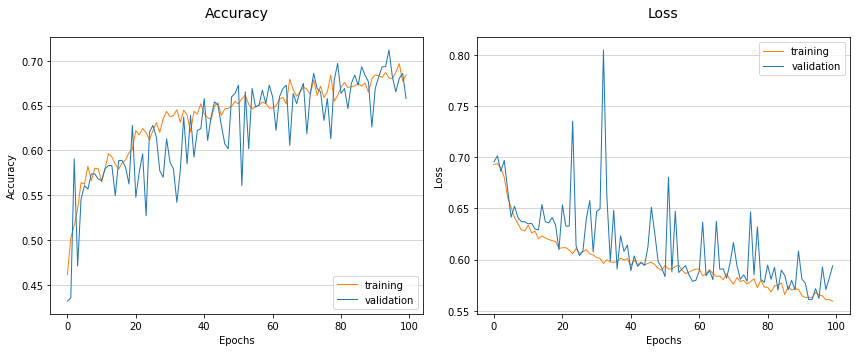

In [22]:
ut.plot_training(history_mc.history['accuracy'], 
                    history_mc.history['loss'], 
                    history_mc.history['val_accuracy'], 
                    history_mc.history['val_loss'], 
                    100,
                    'figures/scratch_bm_64_4.png')

## Evaluation

In [15]:
test_dataset, test_lab = ut.binarize(test_images, test_labels, 'benign_malignant')
test_dataset = ut.rescale(test_dataset)
test_dataset = np.expand_dims(test_dataset, axis=3)

In [23]:
predicted = model.predict(test_dataset, verbose=1)
predicted = [0 if x <=0.5 else 1 for x in predicted]
ut.evaluate_classifier(test_lab, predicted)

11/11 [==============================] - 0s 12ms/step
Performances: 
Accuracy:  0.5178571428571429
Precision:  0.6674987199180746
Recall:  0.5178571428571429
F1-score:  0.5048763736263735
AUC:  0.5943097997892519


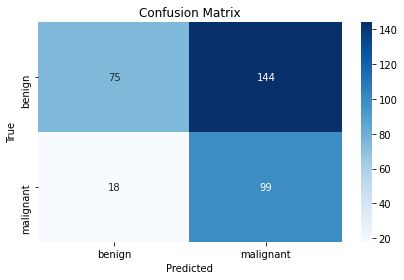

In [24]:
ut.plot_confusion_matrix(test_lab, predicted, ['benign', 'malignant'], 'figures/scratch_bm_cm_64_4.png')